In [ ]:
# Standard library imports
import os
import random
import json
from collections import Counter

# Third-party library imports
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
class CarPartsDataset(Dataset):
    def __init__(self, root_dir, label_mapping_file, transform=None, num_samples_per_model=10):
        """
        Args:
            root_dir (str): Directory with the data organized as:
                /data/NNDL/data/part/{car_make}/{car_model}/{year}/{part}/image.jpg
            label_mapping_file (str): Path to the JSON file containing label_to_idx mapping.
            transform (callable, optional): Optional transform to be applied on a sample.
            num_samples_per_model (int): Number of datapoints to create per car model.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.num_samples_per_model = num_samples_per_model

        # Load the label mapping from JSON file
        with open(label_mapping_file, 'r') as f:
            self.label_to_idx = json.load(f)

        # List to store datapoints as tuples: (list of 8 image paths, label)
        self.data = []
        self._prepare_dataset()

    def _prepare_dataset(self):
        # Iterate over car make folders
        for car_make in os.listdir(self.root_dir):
            path_make = os.path.join(self.root_dir, car_make)
            if not os.path.isdir(path_make):
                continue

            # Iterate over car model folders within a car make
            for car_model in os.listdir(path_make):
                path_model = os.path.join(path_make, car_model)
                if not os.path.isdir(path_model):
                    continue

                # Prepare a dictionary to collect images for each of the 8 parts.
                # We assume the part folders are named "1" through "8".
                parts_images = {str(i): [] for i in range(1, 9)}

                # Loop over each year directory under the current car model.
                for year in os.listdir(path_model):
                    path_year = os.path.join(path_model, year)
                    if not os.path.isdir(path_year):
                        continue

                    # For each part folder (e.g., "1", "2", ..., "8")
                    for part in os.listdir(path_year):
                        path_part = os.path.join(path_year, part)
                        if not os.path.isdir(path_part):
                            continue
                        if part in parts_images:
                            # List all .jpg files in the part folder.
                            for file in os.listdir(path_part):
                                if file.lower().endswith('.jpg'):
                                    full_path = os.path.join(path_part, file)
                                    parts_images[part].append(full_path)

                # If one or more parts do not have any images, skip this car model.
                if not all(len(img_list) > 0 for img_list in parts_images.values()):
                    continue

                # Map the car model to its label using the provided JSON mapping.
                # (Here car_model is the folder name, e.g., "509")
                if car_model not in self.label_to_idx:
                    continue  # skip if not found in the mapping

                label = self.label_to_idx[car_model]

                # Create 'num_samples_per_model' samples by randomly selecting one image per part.
                for _ in range(self.num_samples_per_model):
                    sample_paths = []
                    # Use a consistent order (parts 1 to 8)
                    for part in sorted(parts_images.keys(), key=lambda x: int(x)):
                        chosen_img = random.choice(parts_images[part])
                        sample_paths.append(chosen_img)
                    self.data.append((sample_paths, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns:
            images (list): List of 8 transformed images corresponding to each car part.
            label (int): The remapped car model label.
        """
        image_paths, label = self.data[idx]
        images = []
        for path in image_paths:
            # Open the image and ensure it's in RGB mode.
            img = Image.open(path).convert("RGB")
            if self.transform:
                img = self.transform(img)
            images.append(img)
        return images, label


In [4]:

# Define any image transformations (resize, tensor conversion, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Add normalization or other transforms if needed.
])

# Path to the data directory and the label mapping JSON file.
data_root = "/data/NNDL/data/part"
label_mapping_file = "label_to_idx.json"

# Create the dataset.
dataset = CarPartsDataset(root_dir=data_root,
                            label_mapping_file=label_mapping_file,
                            transform=transform,
                            num_samples_per_model=10)

# Example: Get the first datapoint.
images, label = dataset[0]
print(f"Label: {label}")
print(f"Number of images: {len(images)}")


Label: 218
Number of images: 8


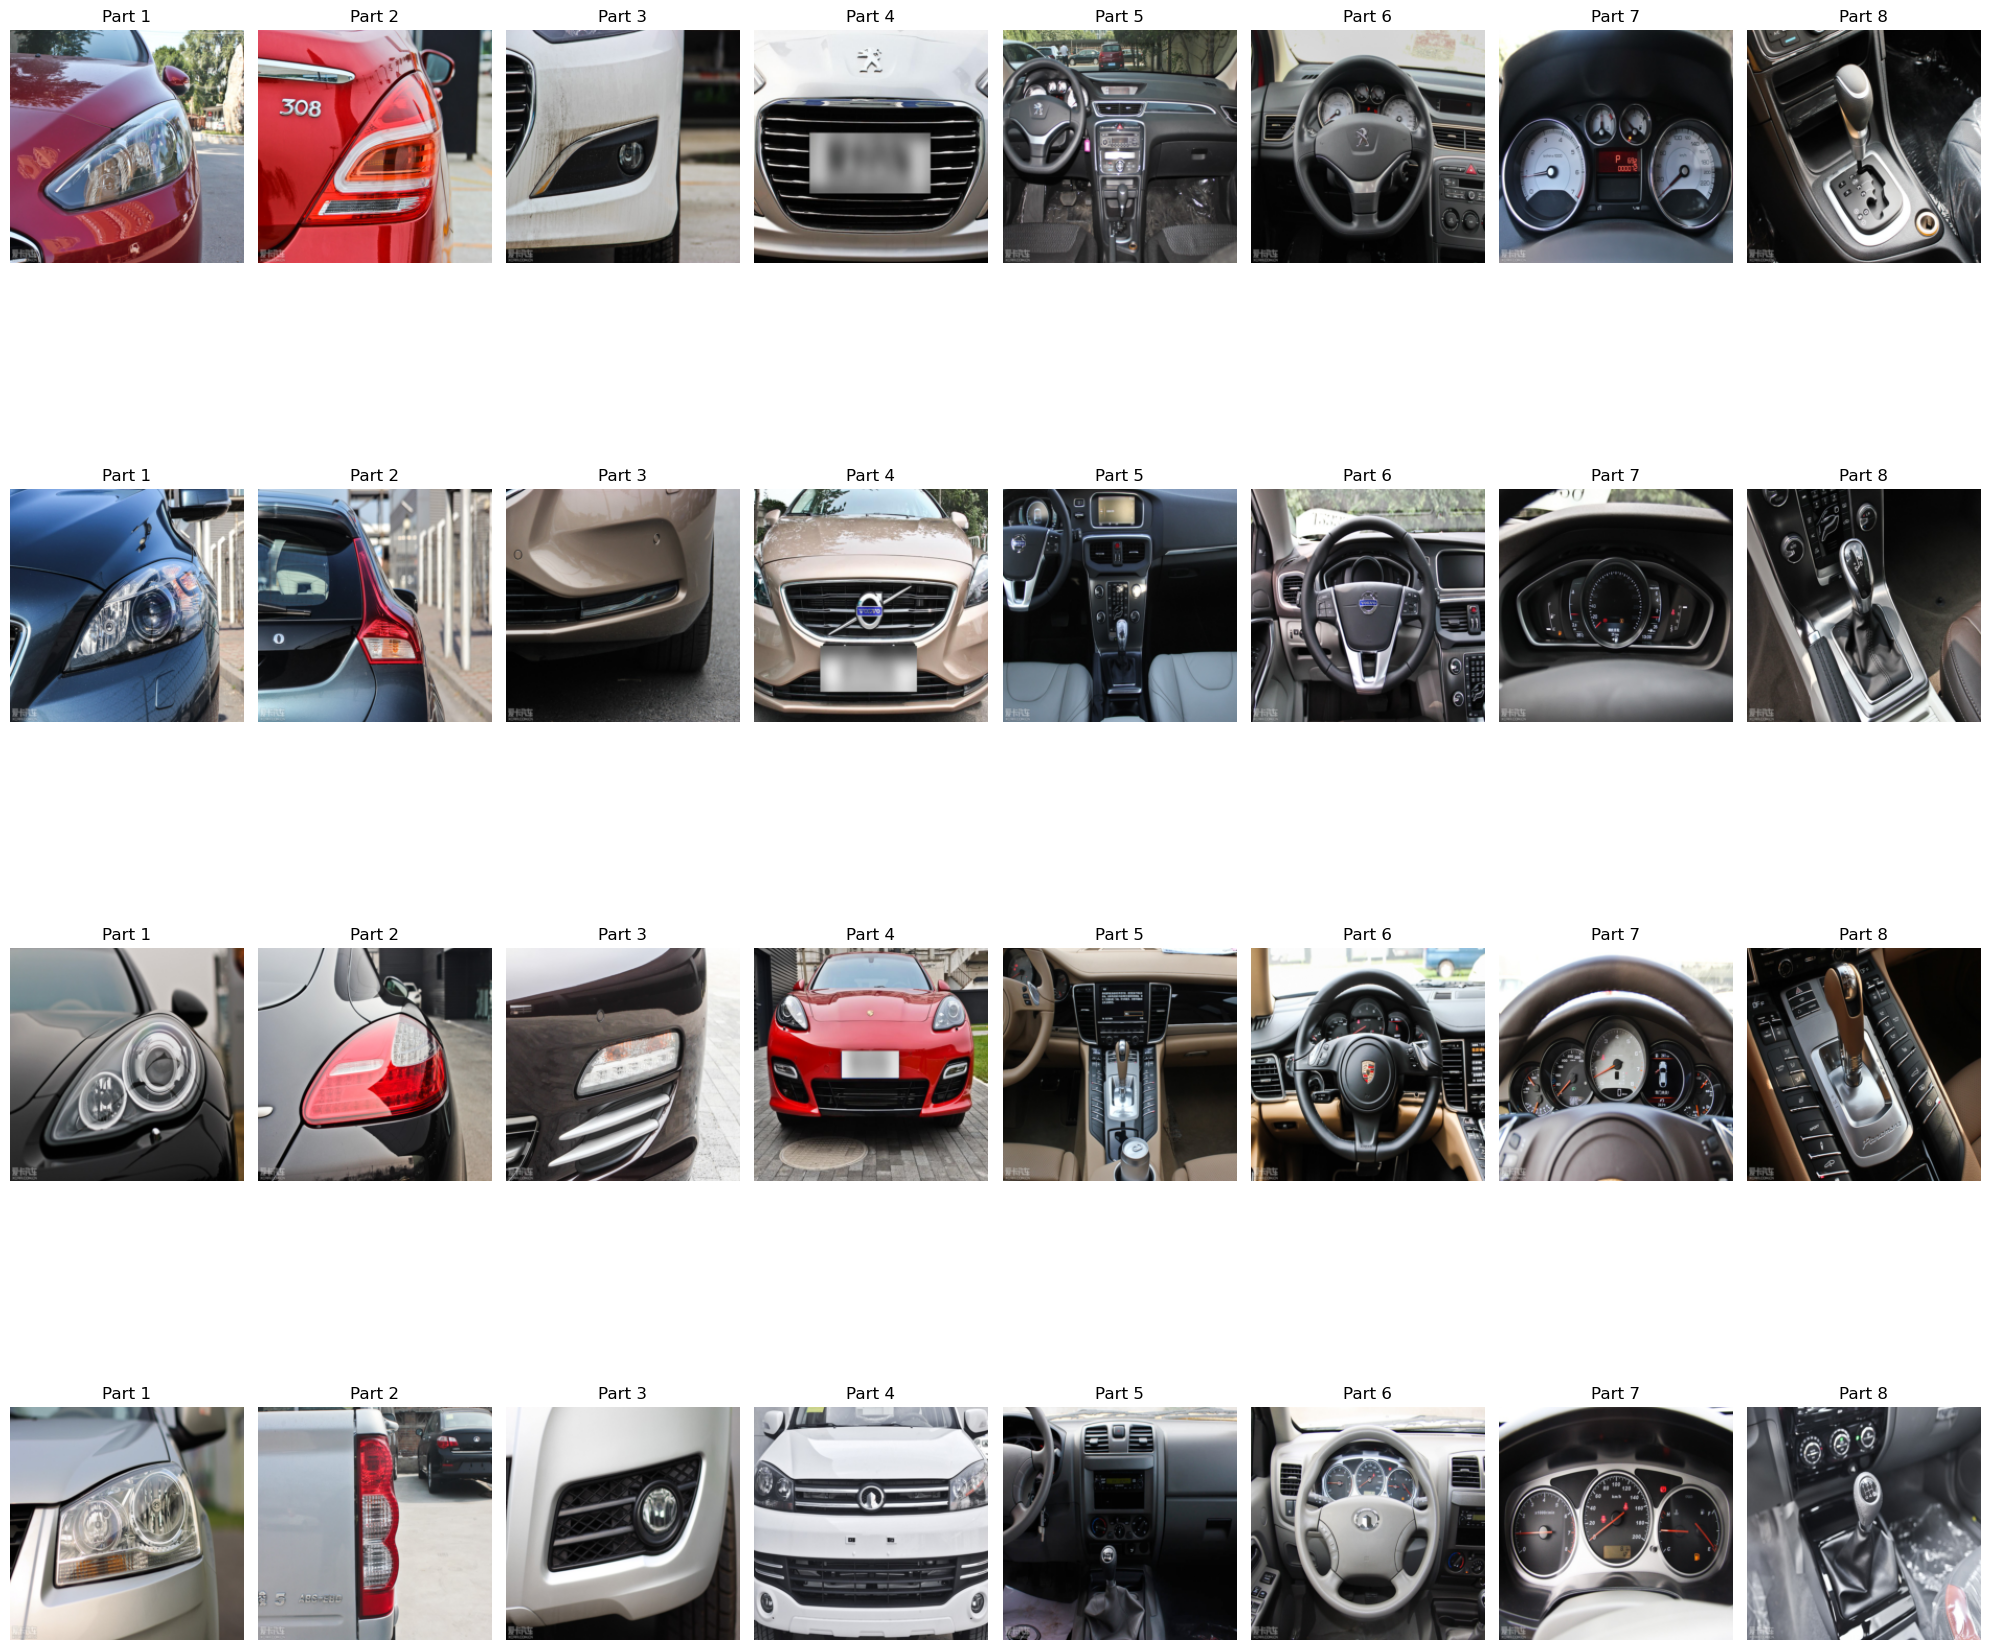

In [ ]:
def plot_random_samples(dataset, num_samples=4):
    """
    Plot several random samples from the dataset.
    
    Args:
        dataset (Dataset): Instance of CarPartsDataset.
        num_samples (int): Number of random samples to plot.
    """
    # Randomly choose indices from the dataset.
    indices = random.sample(range(len(dataset)), num_samples)
    
    # Create a figure with `num_samples` rows and 8 columns.
    fig, axes = plt.subplots(num_samples, 8, figsize=(20, 5*num_samples))
    
    # If there's only one sample, axes will be a 1D array, so wrap it in a list.
    if num_samples == 1:
        axes = [axes]
    
    for row_idx, sample_idx in enumerate(indices):
        images, label = dataset[sample_idx]
        
        # Iterate over the 8 car parts.
        for col_idx, img in enumerate(images):
            # Access the proper axis.
            ax = axes[row_idx][col_idx] if num_samples > 1 else axes[col_idx]
            
            # If the image is a tensor, convert it to a NumPy array for plotting.
            if isinstance(img, torch.Tensor):
                # Convert from (C, H, W) to (H, W, C)
                img_np = img.permute(1, 2, 0).numpy()
                # Clip values in case they're not in [0, 1]
                img_np = img_np.clip(0, 1)
            else:
                img_np = img
                
            ax.imshow(img_np)
            ax.axis('off')
            ax.set_title(f"Part {col_idx+1}")
        
        # Add the car model label as a ylabel for the first column of each row.
        axes[row_idx][0].set_ylabel(f"Label: {label}", fontsize=14, rotation=0, labelpad=50)
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_random_samples(dataset, num_samples=4)


In [ ]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#########################################
# 1. Define a custom collate function
#########################################
def custom_collate(batch):
    """
    Collate function for batching samples where each sample is a tuple:
      (list_of_8_images, label)
    This function groups images per car part and stacks labels.
    """
    images_list, labels = zip(*batch)  # images_list is a tuple of lists, labels is a tuple of ints.
    
    # For each car part, stack the corresponding images across the batch.
    # zip(*images_list) returns a tuple where each element is a tuple containing the i-th image from every sample.
    batch_images = [torch.stack(imgs, dim=0) for imgs in zip(*images_list)]
    batch_labels = torch.tensor(labels)
    return batch_images, batch_labels

#########################################
# 2. Create a DataLoader
#########################################
dataloader = DataLoader(
    dataset, 
    batch_size=32,        # adjust the batch size as needed
    shuffle=False, 
    num_workers= 16, pin_memory=True, prefetch_factor=2, persistent_workers=True,        # adjust based on your CPU cores
    collate_fn=custom_collate
)

#########################################
# 3. Load the models for each car part
#########################################
num_parts = 8
num_classes = len(dataset.label_to_idx)
models_dict = {}

for part_idx in range(1, num_parts+1):
    # Create a ResNet50 model.
    model = models.resnet50(pretrained=False)
    # Replace the final fully connected layer to match the number of classes.
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    # Construct the file name and load the model.
    model_path = f"part_{part_idx}_predictor_resnet50_model.pth"
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    
    model.to(device)
    model.eval()
    models_dict[part_idx] = model
    print(f"Loaded model for part {part_idx} from {model_path}")

#########################################
# 4. Evaluate on the dataset using the DataLoader
#########################################
# Initialize counters.
part_correct = {i: 0 for i in range(1, num_parts+1)}
voting_correct = 0
total_samples = 0

# Iterate over the DataLoader with a progress bar.
for batch_images, batch_labels in tqdm(dataloader, desc="Evaluating batches"):
    batch_size = batch_labels.size(0)
    total_samples += batch_size
    
    # Dictionary to store predictions for each part for this batch.
    batch_predictions = {}
    
    # For each car part, process the batch.
    for part_idx in range(1, num_parts+1):
        # batch_images is a list of 8 tensors; index 0 corresponds to part 1, etc.
        imgs = batch_images[part_idx-1].to(device)  # shape: (batch_size, C, H, W)
        
        with torch.no_grad():
            outputs = models_dict[part_idx](imgs)
            preds = outputs.argmax(dim=1)  # shape: (batch_size,)
            batch_predictions[part_idx] = preds.cpu()  # move to CPU for voting and counting
        
        # Update per-model correct count.
        part_correct[part_idx] += (preds.cpu() == batch_labels).sum().item()
    
    # For each sample in the batch, perform majority voting across the 8 parts.
    for i in range(batch_size):
        sample_preds = [batch_predictions[part_idx][i].item() for part_idx in range(1, num_parts+1)]
        vote_counter = Counter(sample_preds)
        voted_pred, _ = vote_counter.most_common(1)[0]
        if voted_pred == batch_labels[i].item():
            voting_correct += 1

# Calculate and print accuracies.
part_accuracies = {i: part_correct[i] / total_samples for i in range(1, num_parts+1)}
voting_accuracy = voting_correct / total_samples

print("\nPer car part model accuracies:")
for part_idx in range(1, num_parts+1):
    print(f"Part {part_idx}: {part_accuracies[part_idx]*100:.2f}%")
print(f"\nVoting Accuracy: {voting_accuracy*100:.2f}%")


/tmp/ipykernel_210462/3922506775.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Loaded model for part 1 from part_1_predictor_resnet50_model.pth
Loaded model for part 2 from part_2_predictor_resnet50_model.pth
Loaded model for part 3 from part_3_predictor_resnet50_model.pth
Loaded model for part 4 from part_4_predictor_resnet50_model.pth
Loaded model for part 5 from part_5_predictor_resnet50_model.pth
Loaded model for part 6 from part_6_predictor_resnet50_model.pth
Loaded model for part 7 from part_7_predictor_resnet50_model.pth
Loaded model for part 8 from part_8_predictor_resnet50_model.pth


Evaluating batches: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s]


Per car part model accuracies:
Part 1: 0.26%
Part 2: 0.19%
Part 3: 0.23%
Part 4: 0.28%
Part 5: 0.26%
Part 6: 0.07%
Part 7: 0.79%
Part 8: 0.23%

Voting Accuracy: 0.32%


: 